# Exploratory Data Analysis

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from currency_converter import CurrencyConverter
from currency_converter import RateNotFoundError
from datetime import date
import wikipedia

warnings.filterwarnings('ignore')
imdb = pd.read_csv('./IMDB_Movies_2000_2020.csv')

## Dataset Overview

In [5]:
imdb.head(30)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language_1,language_2,...,actors_1,actors_f2,description,desc35,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,reviews_from_users
0,tt0035423,Kate & Leopold,Kate & Leopold,2001,01/03/2002,"Comedy, Fantasy, Romance",118,USA,English,French,...,Meg Ryan,"Meg Ryan, Hugh Jackman",An English Duke from 1876 is inadvertedly drag...,An English Duke from 1876 is inadvertedly,6.4,77852,48000000,47121859.0,76019048,341.0
1,tt0118589,Glitter,Glitter,2001,30/11/2001,"Drama, Music, Romance",104,USA,English,NaN,...,Mariah Carey,"Mariah Carey, Max Beesley",A young singer dates a disc jockey who helps h...,A young singer dates a disc jockey,2.2,21298,22000000,4274407.0,5271666,319.0
2,tt0118694,In the Mood for Love,Fa yeung nin wah,2000,27/10/2000,"Drama, Romance",98,"Hong Kong, China",Cantonese,Shanghainese,...,Maggie Cheung,"Maggie Cheung, Tony Chiu-Wai Leung","Two neighbors, a woman and a man, form a stron...","Two neighbors, a woman and a man,",8.1,119171,NaN,2738980.0,12854953,422.0
3,tt0120202,"Hollywood, Vermont",State and Main,2000,31/05/2002,"Comedy, Drama",105,"France, USA",English,Italian,...,Michael Higgins,"Michael Higgins, Michael Bradshaw",A movie crew invades a small town whose reside...,A movie crew invades a small town,6.7,20220,NaN,6944471.0,9206279,175.0
4,tt0120263,Canzoni del secondo piano,Sånger från andra våningen,2000,06/10/2000,"Comedy, Drama",98,"Sweden, Norway, Denmark",Swedish,Russian,...,Lars Nordh,"Lars Nordh, Stefan Larsson",Where are we humans going? A film poem inspire...,Where are we humans going? A film,7.6,17188,NaN,80334.0,80334,110.0
5,tt0120630,Galline in fuga,Chicken Run,2000,15/12/2000,"Animation, Adventure, Comedy",84,"UK, USA, France",English,NaN,...,Phil Daniels,"Phil Daniels, Lynn Ferguson",When a cockerel apparently flies into a chicke...,When a cockerel apparently flies,7.0,173987,45000000,106834564.0,224834564,393.0
6,tt0120667,I Fantastici 4,Fantastic Four,2005,16/09/2005,"Action, Adventure, Fantasy",106,"USA, Germany",English,NaN,...,Ioan Gruffudd,"Ioan Gruffudd, Jessica Alba",A group of astronauts gain superpowers after a...,A group of astronauts gain superpowers,5.7,307944,100000000,154696080.0,333535934,1029.0
7,tt0120679,Frida,Frida,2002,17/01/2003,"Biography, Drama, Romance",123,"Mexico, USA, Canada",English,French,...,Salma Hayek,"Salma Hayek, Mía Maestro","A biography of artist Frida Kahlo, who channel...","A biography of artist Frida Kahlo,",7.4,79690,12000000,25885000.0,56298474,297.0
8,tt0120681,La vera storia di Jack lo Squartatore,From Hell,2001,21/12/2001,"Horror, Mystery, Thriller",122,"USA, Czech Republic, UK",English,NaN,...,Johnny Depp,"Johnny Depp, Heather Graham","In Victorian-era London, a troubled clairvoyan...","In Victorian-era London, a troubled",6.8,144714,35000000,31602566.0,74558115,556.0
9,tt0120737,Il Signore degli Anelli - La compagnia dell'An...,The Lord of the Rings: The Fellowship of the Ring,2001,18/01/2002,"Action, Adventure, Drama",178,"New Zealand, USA",English,Sindarin,...,Alan Howard,"Alan Howard, Noel Appleby",A meek Hobbit from the Shire and eight compani...,A meek Hobbit from the Shire and,8.8,1619920,93000000,315544750.0,887934303,5392.0


In [6]:
# Column names
imdb.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language_1', 'language_2',
       'language_3', 'director', 'writer', 'actors', 'actors_1', 'actors_f2',
       'description', 'desc35', 'avg_vote', 'votes', 'budget',
       'usa_gross_income', 'worlwide_gross_income', 'reviews_from_users'],
      dtype='object')

In [7]:
def split_names(col):
    array = []
    imdb_sub = imdb.dropna(subset = [col])
    for ind in imdb_sub.index:
        names = imdb_sub.at[ind, col].split(',')
        for name in names:
            array.append(name.strip())
            
    return np.unique(array, return_counts=True)

In [8]:
def combine_name_freq(names, freq, bond = 30):
    # print("--------in function----------")
    names = np.reshape(names, (names.shape[0],1))
    freq = np.reshape(freq, (freq.shape[0],1))
    names = np.concatenate((names, freq),axis=1)

    data= pd.DataFrame({"names": names[:,0], "num": names[:,1].astype(np.int)})
    data = data.sort_values(by = ['num'], ascending = False)
    
    if(bond>0):
        # print(data)
        minority = data[data.num<bond]
        # print("minority")
        # print(minority)
        sum1 = minority.sum()
        data_new  = data[data.num>=bond]
        data_new = pd.concat([data_new, pd.DataFrame({"num": sum1.num}, index = ['Others'])])
        # -------After sorting-----------
        data = data_new.sort_values(by = ['num'],ascending = False)
    return data

In [9]:
def relation_plot(df, cmap = 'RdPu', xlog = False, ylog = False,figsize = (20, 10)):
    
    columns = df.columns
    df = df.astype(int)
    colors = np.random.rand(len(df))
    # print(df)
    fig = plt.figure(figsize=figsize, dpi=80)
    ax = plt.gca()
    if(xlog): ax.set_xscale('log')
    if(ylog): ax.set_yscale('log')
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.scatter(df[columns[0]], df[columns[1]], c=colors, alpha = 0.2, cmap = cmap)
    plt.show()

## Relation between Film Budgets and Incomes

In [10]:
def currency_conv(col, df):
    # convert all currency into USD
    df_sub = []
    for ind in df.index:
        if(df.at[ind, col].isnumeric() == False):
            df_sub.append(df.loc[ind])
            df = df.drop(index=ind)
    df_sub = pd.DataFrame(df_sub, columns = df.columns)
    c = CurrencyConverter(decimal=True)
    for ind in df_sub.index:
        temp_str = df_sub.at[ind, col]
        currency = temp_str[0:3]
        amount = int(temp_str[3:].strip())
        try:
            converted = c.convert(amount, currency.strip(), 'USD', date=date(2022, 3, 31))
        except ValueError:
            df_sub = df_sub.drop(index=ind)
        except RateNotFoundError:
            df_sub = df_sub.drop(index=ind)
        else:
            df_sub.at[ind, col] = float(converted)

    #print(non_dollars.to_string())
    df = pd.concat([df, df_sub])
    df.sort_index()
    return df
    

In [11]:
def split_cols(colList):
    # separate two columns from the database
    imdb_sub = imdb.dropna(subset = colList)
    imdb_sub = imdb_sub[colList]
    return imdb_sub

In [12]:
print(imdb.columns)

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language_1', 'language_2',
       'language_3', 'director', 'writer', 'actors', 'actors_1', 'actors_f2',
       'description', 'desc35', 'avg_vote', 'votes', 'budget',
       'usa_gross_income', 'worlwide_gross_income', 'reviews_from_users'],
      dtype='object')


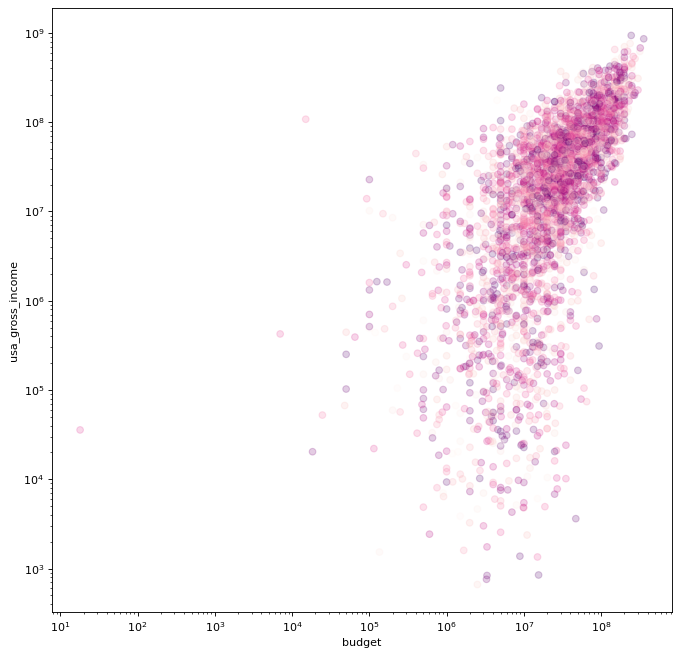

In [13]:
budget_usa_income = split_cols(['budget','usa_gross_income'])
budget_usa_income = currency_conv('budget', budget_usa_income)
# print(budget_usa_income)
relation_plot(budget_usa_income, xlog = True, ylog = True,figsize=(10,10))

This plot is about the relationship between budgets and USA gross incomes, and it shows that more budgets will bring more USA incomes for most films. Some movies have a minimal budget but earn more USA income, and some films have a huge budget but only earn a little USA income, but much less.

           budget worlwide_gross_income
0        48000000              76019048
1        22000000               5271666
5        45000000             224834564
6       100000000             333535934
7        12000000              56298474
...           ...                   ...
5373       923610                  3417
5383      24637.9              27590180
5384  2.63889e+06                536525
5422  5.93749e+06              39346577
5426  2.88626e+06               2027391

[4032 rows x 2 columns]


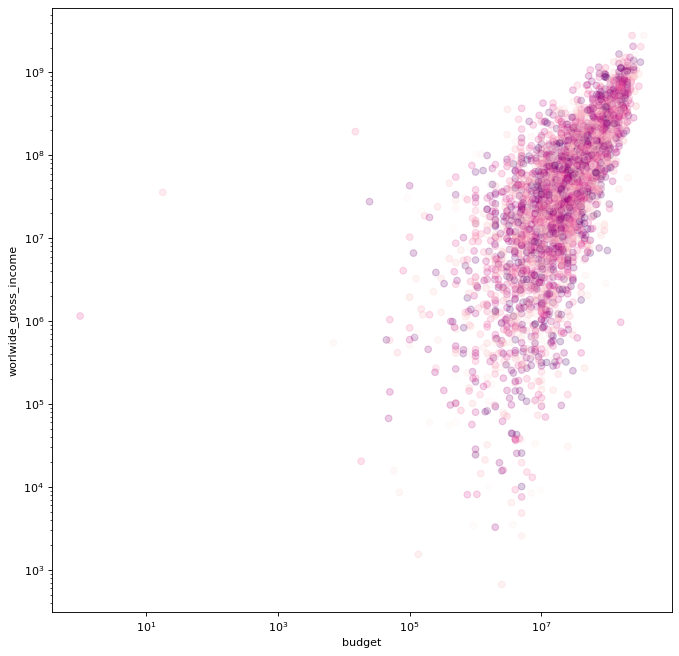

In [14]:
budget_income = split_cols(['budget','worlwide_gross_income'])
budget_income = currency_conv('budget', budget_income)
budget_income = currency_conv('worlwide_gross_income', budget_income)
print(budget_income)
relation_plot(budget_income, xlog=True, ylog = True,figsize=(10,10))

This plot is about the relationship between budgets and worldwide gross incomes. This plot is similar to the "budget vs. usa_gross_income" plot but more concentrated. It shows that more budgets will bring more USA incomes for most films. The number of films that cannot be applied to this observation is less than the above plot.

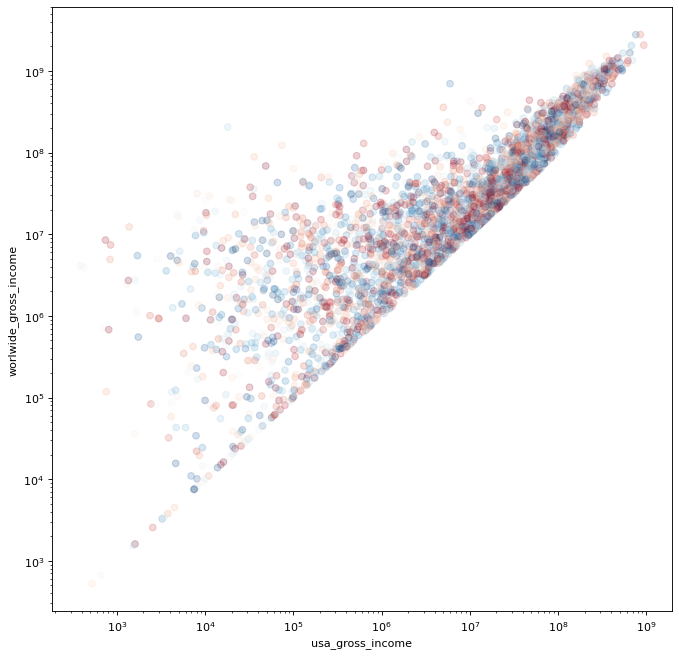

In [15]:
usa_world_income = split_cols(['usa_gross_income', 'worlwide_gross_income'])
usa_world_income = currency_conv('worlwide_gross_income', usa_world_income)
relation_plot(usa_world_income, cmap='RdBu', xlog=True, ylog=True, figsize=(10,10))

Then we also show the relation between USA gross incomes and worldwide gross incomes. There is an obvious line because the worldwide gross revenue is always larger than the USA's gross income. From 10^3 to 10^7, a lot of films have much more worldwide gross incomes than USA gross incomes. For movies with USA gross incomes larger than 10^7, their worldwide gross revenues have the same order of magnitude.

## Profit = income - budget

In [16]:
print(budget_income.shape)
print(type(budget_income))
print(budget_income)


(4032, 2)
<class 'pandas.core.frame.DataFrame'>
           budget worlwide_gross_income
0        48000000              76019048
1        22000000               5271666
5        45000000             224834564
6       100000000             333535934
7        12000000              56298474
...           ...                   ...
5373       923610                  3417
5383      24637.9              27590180
5384  2.63889e+06                536525
5422  5.93749e+06              39346577
5426  2.88626e+06               2027391

[4032 rows x 2 columns]


In [17]:
budget_and_income = split_cols(['budget','usa_gross_income','worlwide_gross_income'])
budget_and_income = currency_conv('budget', budget_and_income)
budget_and_income = currency_conv('worlwide_gross_income', budget_and_income)
print(budget_and_income)

           budget  usa_gross_income worlwide_gross_income
0        48000000        47121859.0              76019048
1        22000000         4274407.0               5271666
5        45000000       106834564.0             224834564
6       100000000       154696080.0             333535934
7        12000000        25885000.0              56298474
...           ...               ...                   ...
5339   3.4069e+07         7743794.0              31626978
5383      24637.9           52406.0              27590180
5384  2.63889e+06          182009.0                536525
5422  5.93749e+06         4186168.0              39346577
5426  2.88626e+06          817339.0               2027391

[3675 rows x 3 columns]


In [18]:
budget = np.array(budget_and_income["budget"].astype('float'))
worldIncome = np.array(budget_and_income["worlwide_gross_income"].astype('float'))
USIncome = np.array(budget_and_income["usa_gross_income"].astype('float'))
world_net_income = (worldIncome-budget).reshape((-1,))
usa_net_income = (USIncome-budget).reshape((-1,))
world_net_income = pd.DataFrame({"world_net_income": world_net_income})
usa_net_income = pd.DataFrame({"usa_net_income": usa_net_income})
# print(world_net_income)
# print(usa_net_income)

normalized_world = (world_net_income-world_net_income.mean())/world_net_income.std()
print(normalized_world)
normalized_usa = (usa_net_income-usa_net_income.mean())/usa_net_income.std()
print(normalized_usa)

      world_net_income
0            -0.304408
1            -0.557464
2             0.554140
3             0.857833
4            -0.212345
...                ...
3670         -0.476672
3671         -0.306973
3672         -0.474751
3673         -0.273927
3674         -0.467719

[3675 rows x 1 columns]
      usa_net_income
0          -0.205660
1          -0.510650
2           0.929629
3           0.800401
4           0.061597
...              ...
3670       -0.666328
3671       -0.189260
3672       -0.234240
3673       -0.221467
3674       -0.227217

[3675 rows x 1 columns]


## Keywords in descriptions

In [19]:
budget_and_income = split_cols(['budget','usa_gross_income','worlwide_gross_income','description', 'original_title', 'avg_vote'])
budget_and_income = currency_conv('budget', budget_and_income)
budget_and_income = currency_conv('worlwide_gross_income', budget_and_income)
budget_and_income = budget_and_income.reset_index(drop=True)
print(budget_and_income)

budget = np.array(budget_and_income["budget"].astype('float'))
world_income = np.array(budget_and_income["worlwide_gross_income"].astype('float'))
US_income = np.array(budget_and_income["usa_gross_income"].astype('float'))
world_net_income = (world_income-budget).reshape((-1,))
usa_net_income = (US_income-budget).reshape((-1,))
world_net_income = pd.DataFrame({"world_net_income": world_net_income})
usa_net_income = pd.DataFrame({"usa_net_income": usa_net_income})
print(world_net_income)
print(usa_net_income)

normalized_world = (world_net_income-world_net_income.mean())/world_net_income.std()
print(normalized_world)
normalized_usa = (usa_net_income-usa_net_income.mean())/usa_net_income.std()
print(normalized_usa)

           budget  usa_gross_income worlwide_gross_income  \
0        48000000        47121859.0              76019048   
1        22000000         4274407.0               5271666   
2        45000000       106834564.0             224834564   
3       100000000       154696080.0             333535934   
4        12000000        25885000.0              56298474   
...           ...               ...                   ...   
3670   3.4069e+07         7743794.0              31626978   
3671      24637.9           52406.0              27590180   
3672  2.63889e+06          182009.0                536525   
3673  5.93749e+06         4186168.0              39346577   
3674  2.88626e+06          817339.0               2027391   

                                            description  \
0     An English Duke from 1876 is inadvertedly drag...   
1     A young singer dates a disc jockey who helps h...   
2     When a cockerel apparently flies into a chicke...   
3     A group of astronauts gai

In [20]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(pd.DataFrame(budget_and_income['avg_vote']).sort_values(by=['avg_vote'], ascending=False))

In [21]:
descriptions = []
for string in budget_and_income.description:
    descriptions.append(string)
print(descriptions[0])
descriptions = pd.DataFrame({"description": descriptions})
# print(descriptions)
desp_prof = pd.concat((descriptions, normalized_world, pd.DataFrame(budget_and_income['original_title']),pd.DataFrame(budget_and_income['avg_vote'])),axis=1)
print(desp_prof)

An English Duke from 1876 is inadvertedly dragged to modern day New York where he falls for a plucky advertising executive.
                                            description  world_net_income  \
0     An English Duke from 1876 is inadvertedly drag...         -0.304408   
1     A young singer dates a disc jockey who helps h...         -0.557464   
2     When a cockerel apparently flies into a chicke...          0.554140   
3     A group of astronauts gain superpowers after a...          0.857833   
4     A biography of artist Frida Kahlo, who channel...         -0.212345   
...                                                 ...               ...   
3670  Beneath Anna Poliatova's striking beauty lies ...         -0.476672   
3671  Things go badly for a hack director and film c...         -0.306973   
3672  Two friends and a chirpy teenager take a road ...         -0.474751   
3673  Indian army special forces execute a covert op...         -0.273927   
3674  French dancers gather i

In [22]:
def split_words(col):
    array = []
    df_sub = imdb.dropna(subset = [col])
    for ind in df_sub.index:
        words = re.split('\s',df_sub.at[ind, col].lower())
        words = [word for word in words if len(word)!=0]
        words = [re.sub("[^a-zA-Z0-9']", '',word) for word in words]
        for word in words:
            if(word!=''):
                array.append(word)
            
    return np.unique(array, return_counts=True)

In [23]:
def split_words_with_prof(df, col, df_prof):
    array = []

    for ind in df.index:
        words = re.split('\s',df.at[ind, col].lower())
        words = [word for word in words if len(word)!=0]
        words = [re.sub("[^a-zA-Z0-9']", '',word) for word in words]
        for word in words:
            if(word!='' and word not in stopwords):
                cols = df_prof.columns
                # print(cols[0])
                array.append((word, float(df_prof.at[ind,cols[0]]), df.at[ind, 'original_title'], df.at[ind, 'avg_vote']))
    words_cnt = pd.DataFrame(array)
    cols = words_cnt.columns
    grouped_words = words_cnt.groupby([cols[0]])
    
    return pd.DataFrame(grouped_words.sum())

In [24]:
stopwords = "i,me,my,myself,we,us,our,ours,ourselves,you,your,yours,yourself,yourselves,he,him,his,himself,she,her,hers,herself,it,its,itself,they,them,their,theirs,themselves,what,which,who,whom,whose,this,that,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,will,would,should,can,could,ought,i'm,you're,he's,she's,it's,we're,they're,i've,you've,we've,they've,i'd,you'd,he'd,she'd,we'd,they'd,i'll,you'll,he'll,she'll,we'll,they'll,isn't,aren't,wasn't,weren't,hasn't,haven't,hadn't,doesn't,don't,didn't,won't,wouldn't,shan't,shouldn't,can't,cannot,couldn't,mustn't,let's,that's,who's,what's,here's,there's,when's,where's,why's,how's,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,upon,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,say,says,said,shall".split(",")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'whose', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'will', 'would', 'should', 'can', 'could', 'ought', "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've", "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", 'cannot', "couldn't", "mustn't", "let's", "that's", "who's", "what's", "here's", "there's", "when's", "where's", "why's", "how's", 'a', 'a

In [25]:
import re
array = []
df = desp_prof
df_prof = normalized_world
col = "description"
for ind in df.index:
    words = re.split('\s',df.at[ind, col].lower())
    words = [word for word in words if len(word)!=0]
    words = [re.sub("[^a-zA-Z0-9']", '',word) for word in words]
    for word in words:
        if(word!='' and word not in stopwords):
            cols = df_prof.columns
            # print(cols[0])
            array.append((word, float(df_prof.at[ind,cols[0]]), df.at[ind, 'original_title'], df.at[ind, 'avg_vote']))
words_cnt = pd.DataFrame(array)

In [26]:
print(words_cnt)
cols = words_cnt.columns
# print(cols)
grouped_words = words_cnt.groupby(by = [cols[0]])
# print(grouped_words.groups)

                  0         1               2    3
0           english -0.304408  Kate & Leopold  6.4
1              duke -0.304408  Kate & Leopold  6.4
2              1876 -0.304408  Kate & Leopold  6.4
3      inadvertedly -0.304408  Kate & Leopold  6.4
4           dragged -0.304408  Kate & Leopold  6.4
...             ...       ...             ...  ...
56046     nightmare -0.467719          Climax  7.1
56047         learn -0.467719          Climax  7.1
56048       sangria -0.467719          Climax  7.1
56049         laced -0.467719          Climax  7.1
56050           lsd -0.467719          Climax  7.1

[56051 rows x 4 columns]


In [27]:
words = split_words_with_prof(desp_prof, "description" , normalized_world)

In [28]:

words = pd.DataFrame(words[1]).sort_values(by = [1], ascending = False)

words_cnt = pd.DataFrame(words[1])
print(words_cnt)
words_cnt.reset_index(inplace=True)
print(words_cnt)
words_cnt[1] = (words_cnt[1]-words_cnt[1].mean())/words_cnt[1].std()
words_cnt[1] = words_cnt[1].round().astype(int)

maxNumber = 500
words_cnt = words_cnt.head(maxNumber)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
print(words_cnt)

                1
0                
must    89.923303
world   86.708800
new     72.158983
threat  42.257015
team    37.769374
...           ...
love   -35.789989
woman  -38.286971
two    -45.900602
young  -49.355587
man    -56.909321

[12543 rows x 1 columns]
            0          1
0        must  89.923303
1       world  86.708800
2         new  72.158983
3      threat  42.257015
4        team  37.769374
...       ...        ...
12538    love -35.789989
12539   woman -38.286971
12540     two -45.900602
12541   young -49.355587
12542     man -56.909321

[12543 rows x 2 columns]
            0   1
0        must  28
1       world  27
2         new  23
3      threat  13
4        team  12
..        ...  ..
495     curry   2
496    trials   2
497    secret   2
498   divided   1
499  galactic   1

[500 rows x 2 columns]


In [29]:
list_ver = words_cnt[[0,1]].to_numpy()
print(type(list_ver[0][0]))
f = open("keywords_world.txt", "w")
word_frq = "['{0}',{1}]"
f.write('[')
for list in list_ver:
    if('\'' in list[0]): 
        index = list[0].find('\'')
        list[0] = list[0][:index] + '\\' + list[0][index:] 
    f.write(word_frq.format(list[0],list[1]))
    if(list[0]!=list_ver[-1][0]): f.write(',\n')
f.write(']')
f.close()

<class 'str'>


In [30]:
words_usa = split_words_with_prof(desp_prof, "description" , normalized_usa)

words_usa = pd.DataFrame(words_usa[1]).sort_values(by = [1], ascending = False)

words_usa = pd.DataFrame(words_usa[1])
words_usa.reset_index(inplace=True)
words_usa = words_usa.drop(index = 0)
words_usa = words_usa.drop(index = 1)
words_usa = words_usa.drop(index = 2)
words_usa[1] = (words_usa[1]-words_usa[1].mean())/words_usa[1].std()
words_usa[1] = words_usa[1].round().astype(int)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(words_cnt)
list_ver = words_usa[[0,1]].to_numpy()
f = open("keywords_usa.txt", "w")
word_frq = "['{0}',{1}]"
f.write('[')
for list in list_ver:
    if('\'' in list[0]): 
        index = list[0].find('\'')
        list[0] = list[0][:index] + '\\' + list[0][index:]
    f.write(word_frq.format(list[0],list[1]))
    if(list[0]!=list_ver[-1][0]): f.write(',\n')
f.write(']')
f.close()

KeyboardInterrupt: 

## Directors with published date and net profit

In [ ]:
from datetime import datetime
# print(imdb.dtypes)
for ind in imdb.index:
    if(imdb.at[ind, 'date_published']!=None):  
        # print("converting: ", imdb.at[ind, 'date_published'])
        imdb.at[ind, 'date_published'] = datetime.strptime(imdb.at[ind, 'date_published'],'%d/%m/%Y')
# print(imdb.dtypes)

In [ ]:
directors = imdb["director"]
print(directors)
# for director in directors:
#     if ',' in director:
#         print("found \',\' in", director)

0            James Mangold
1       Vondie Curtis-Hall
2             Kar-Wai Wong
3              David Mamet
4            Roy Andersson
               ...        
5482             Spike Lee
5483        Vince Marcello
5484         Jérémy Clapin
5485          Roger Kumble
5486         Michael Dowse
Name: director, Length: 5487, dtype: object


In [ ]:
from selenium import webdriver
import time
import os
import re
import requests
from PIL import Image
from PIL import UnidentifiedImageError
from io import BytesIO
from selenium.webdriver.common.by import By

class Crawler_google_images:
    # 初始化
    def __init__(self, keyword, keyword2, browser):
        keyword_url = keyword.replace('&', ' ').replace('?', ' ').replace('/', ' ').replace('+', ' ').replace('%',' ').replace('#',' ')
        # print("keyword_url: ", keyword_url)
        if(keyword2!=None):
            self.url = 'https://www.bing.com/images/search?q='+keyword_url+keyword2 +'&tbm=isch'
        else:
            self.url = 'https://www.bing.com/images/search?q='+keyword_url +'&tbm=isch'
        self.keyword = keyword
        self.browser = browser

    # 获得Chrome驱动，并访问url
    def init_browser(self):
        # 访问url
        browser.get(self.url)
        # 最大化窗口，之后需要爬取窗口中所见的所有图片
        browser.maximize_window()
        return browser

    #下载图片
    def get_image_url(self, browser,round=2):
        count = 0 #图片序号
        pos = 0
        for i in range(round):
            pos += 500
            # 向下滑动
            js = 'var q=document.documentElement.scrollTop=%d'%pos
            browser.execute_script(js)
            time.sleep(1)
            # 找到图片
            # html = browser.page_source#也可以抓取当前页面的html文本，然后用beautifulsoup来抓取
            #直接通过tag_name来抓取是最简单的，比较方便

            img_elements = browser.find_elements(By.CLASS_NAME, 'iusc')
            # print(img_elements)
            for img_element in img_elements:
                m = img_element.get_attribute('m')
                # print(m)
                try:
                    img_url = re.findall("murl\":\"https?://[^\s]*.jpg", m)
                    # print(img_url[0][7:])
                    img_url = img_url[0][7:]
                except (TypeError, IndexError):
                    # print("No match for img_url, finding next")
                    continue
                try:
                    r = requests.get(img_url)
                    img = Image.open(BytesIO(r.content))
                    width, height = img.size
                    # print("width: ", width , ", height: ", height)
                    if(height>width):
                        return img_url
                except UnidentifiedImageError:
                    # print("UnidentifiedImageError, finding next")
                    continue
                except (requests.exceptions.ConnectionError, requests.exceptions.SSLError, requests.exceptions.TooManyRedirects):
                    continue
                    # print("requests exceptions, finding next")
                #防止反爬机制
                time.sleep(0.2)

    def run(self):
        browser = self.init_browser()
        image_url = self.get_image_url(browser,10)#可以修改爬取的页面数，基本10页是100多张图片
        # browser.close()
        return image_url


def fetchImage(browser,keyword = 'Your Name.', keyword2=None):
    # print("fetching image for ", keyword)
    craw = Crawler_google_images(keyword,keyword2, browser)
    return craw.run()

In [ ]:
signs = ['%', '#']
for ind in imdb.index:
    for operand in signs:
        if(operand in imdb.at[ind,"original_title"]): print(imdb.at[ind,"original_title"])
        if(operand in imdb.at[ind,"director"]): print(imdb.at[ind,"director"])



In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--disable-infobars")
browser = webdriver.Chrome(chrome_options=chrome_options)
keyword = 'Tristan + Isolde'
fetchImage(browser, keyword, ' film poster')

'https://i.pinimg.com/originals/5a/ec/aa/5aecaa653d03cfef157fcb1abad0ad5a.jpg'

In [ ]:
director_prof = split_cols(['original_title','budget','usa_gross_income','worlwide_gross_income','director','date_published'])
director_prof = currency_conv('budget', director_prof)
director_prof = currency_conv('worlwide_gross_income', director_prof)
director_prof = director_prof.reset_index()

# print(director_prof.dtypes)
budget = np.array(director_prof["budget"].astype('float'))
world_income = np.array(director_prof["worlwide_gross_income"].astype('float'))
US_income = np.array(director_prof["usa_gross_income"].astype('float'))
world_net_income = (world_income-budget).reshape((-1,))
usa_net_income = (US_income-budget).reshape((-1,))
world_net_income = pd.DataFrame({"world_net_income": world_net_income})
usa_net_income = pd.DataFrame({"usa_net_income": usa_net_income})
# print(world_net_income)
# print(usa_net_income)
print(director_prof)

      index            original_title       budget  usa_gross_income  \
0         0            Kate & Leopold     48000000        47121859.0   
1         1                   Glitter     22000000         4274407.0   
2         5               Chicken Run     45000000       106834564.0   
3         6            Fantastic Four    100000000       154696080.0   
4         7                     Frida     12000000        25885000.0   
...     ...                       ...          ...               ...   
3670   5339                      Anna   3.4069e+07         7743794.0   
3671   5383       Kamera wo tomeruna!      24637.9           52406.0   
3672   5384                   Karwaan  2.63889e+06          182009.0   
3673   5422  Uri: The Surgical Strike  5.93749e+06         4186168.0   
3674   5426                    Climax  2.88626e+06          817339.0   

     worlwide_gross_income               director       date_published  
0                 76019048          James Mangold  2002-03-01 

In [ ]:
for ind in director_prof.index:
    if(director_prof.at[ind, 'original_title'] == 'In the Bedroom'):
        print(ind)
        print(director_prof.loc[ind,:])

292
index                                    344
original_title                In the Bedroom
budget                               1700000
usa_gross_income                 3.59306e+07
worlwide_gross_income               44763181
director                          Todd Field
date_published           2002-03-15 00:00:00
Name: 292, dtype: object


In [ ]:
def split_names_with_prof(df_prof):
    array = []
    f = open("directors_new.txt", "w+")
    f.write('[')
    
    word_frq = "[{0},{1},{2},{3},'{4}', '{5}', '{6}','{7}']"
    for ind in range(293, len(director_prof.index)):
        # print("indexing ", ind)
        names = re.split(',', director_prof.at[ind, 'director'])
        for name in names:
            if(name!=''):
                cols = df_prof.columns
                link_director = fetchImage(browser, name, ' director')
                link_poster = fetchImage(browser, director_prof.at[ind, 'original_title'], ' film poster')
                # print("link for director: ", link_director)
                # print("link for poster: ", link_poster)
                date_temp = director_prof.at[ind, 'date_published']
                formatted_str = word_frq.format(date_temp.year, date_temp.month, date_temp.day, df_prof.at[ind, cols[0]], name, director_prof.at[ind, 'original_title'], link_director, link_poster)
                print(formatted_str)
                f.write(formatted_str)
                f.write(',\n')
                array.append([name, date_temp, df_prof.at[ind, cols[0]],director_prof.at[ind, 'original_title']])
    f.write(']')
    f.close()
    print("fetching over")
    return


In [ ]:
director_prof_world = split_names_with_prof(world_net_income)
# print(director_prof_world)
director_prof_world = director_prof_world.sort_values(by=[2])

NameError: name 'split_names_with_prof' is not defined

In [31]:
director_prof_world = pd.read_csv('directors_2.txt',sep="\n",header=None)
print(director_prof_world)

                                                      0
0     2002; 3; 1; 28019048; James Mangold; Kate & Le...
1     2001; 11; 30; -16728334; Vondie Curtis-Hall; G...
2     2000; 12; 15; 179834564; Peter Lord; Chicken R...
3     2000; 12; 15; 179834564;  Nick Park; Chicken R...
4     2005; 9; 16; 233535934; Tim Story; Fantastic F...
...                                                 ...
3931  2019; 6; 21; -2441991; Luc Besson; Anna; https...
3932  2018; 11; 7; 27565542.136568766; Shin'ichirô U...
3933  2018; 8; 3; -2102360.5872774385; Akarsh Khuran...
3934  2019; 1; 11; 33409084.428625762; Aditya Dhar; ...
3935  2019; 6; 13; -858869; Gaspar Noé; Climax; http...

[3936 rows x 1 columns]


In [32]:
array = []
for ind in director_prof_world.index:
    terms = str(director_prof_world.at[ind,0]).split(';')
    # print(terms)
    array.append(terms)

In [33]:
for texts in array:
    if(len(texts)>8):print(texts)

In [34]:
director_prof_world = pd.DataFrame(array)
director_prof_world = director_prof_world.sort_values(by = [0,1,2])
print(director_prof_world)

         0    1    2                    3                  4  \
3766  1905    6   30   28421076.285184436       Anees Bazmee   
2038  1905    7    6              3522511    Aaron Schneider   
158   2000    1   12             48827328         Steve Carr   
38    2000   10   13            -18567273      Bibo Bergeron   
39    2000   10   13            -18567273           Don Paul   
...    ...  ...  ...                  ...                ...   
3588  2020    7    1             34783103   Johannes Roberts   
3625  2020    7    1             59790499       Gail Mancuso   
3635  2020    8   19             16966625         Oz Perkins   
3434  2020    8    6             25279888    Elizabeth Banks   
3537  2020    9   17            -73750531       Chris Butler   

                             5  \
3766            Singh Is Kinng   
2038                   Get Low   
158                Next Friday   
38       The Road to El Dorado   
39       The Road to El Dorado   
...                        

In [35]:
print(director_prof_world.reset_index(drop=True))

         0    1    2                    3                  4  \
0     1905    6   30   28421076.285184436       Anees Bazmee   
1     1905    7    6              3522511    Aaron Schneider   
2     2000    1   12             48827328         Steve Carr   
3     2000   10   13            -18567273      Bibo Bergeron   
4     2000   10   13            -18567273           Don Paul   
...    ...  ...  ...                  ...                ...   
3931  2020    7    1             34783103   Johannes Roberts   
3932  2020    7    1             59790499       Gail Mancuso   
3933  2020    8   19             16966625         Oz Perkins   
3934  2020    8    6             25279888    Elizabeth Banks   
3935  2020    9   17            -73750531       Chris Butler   

                             5  \
0               Singh Is Kinng   
1                      Get Low   
2                  Next Friday   
3        The Road to El Dorado   
4        The Road to El Dorado   
...                        

In [37]:
print(director_prof_world.reset_index(drop=True)[5])
print(director_prof_world.reset_index(drop=True)[7])

0                 Singh Is Kinng
1                        Get Low
2                    Next Friday
3          The Road to El Dorado
4          The Road to El Dorado
                  ...           
3931     47 Meters Down: Uncaged
3932             A Dog's Journey
3933             Gretel & Hansel
3934            Charlie's Angels
3935                Missing Link
Name: 5, Length: 3936, dtype: object
0        https://images-na.ssl-images-amazon.com/image...
1        https://m.media-amazon.com/images/M/MV5BMTY3M...
2        https://i.etsystatic.com/28533358/r/il/331641...
3        https://cdn.traileraddict.com/content/dreamwo...
4        https://cdn.traileraddict.com/content/dreamwo...
                              ...                        
3931     http://de.web.img2.acsta.net/pictures/19/07/1...
3932     https://www.dvdsreleasedates.com/posters/800/...
3933     https://i.pinimg.com/originals/3f/a2/56/3fa25...
3934       https://picfiles.alphacoders.com/808/80861.jpg
3935     https://pic

In [39]:
movie_Img = pd.concat([director_prof_world.reset_index(drop=True)[5], director_prof_world.reset_index(drop=True)[7]], axis=1)
print(movie_Img)
director_img = pd.concat([director_prof_world.reset_index(drop=True)[4], director_prof_world.reset_index(drop=True)[6]], axis=1)


                             5  \
0               Singh Is Kinng   
1                      Get Low   
2                  Next Friday   
3        The Road to El Dorado   
4        The Road to El Dorado   
...                        ...   
3931   47 Meters Down: Uncaged   
3932           A Dog's Journey   
3933           Gretel & Hansel   
3934          Charlie's Angels   
3935              Missing Link   

                                                      7  
0      https://images-na.ssl-images-amazon.com/image...  
1      https://m.media-amazon.com/images/M/MV5BMTY3M...  
2      https://i.etsystatic.com/28533358/r/il/331641...  
3      https://cdn.traileraddict.com/content/dreamwo...  
4      https://cdn.traileraddict.com/content/dreamwo...  
...                                                 ...  
3931   http://de.web.img2.acsta.net/pictures/19/07/1...  
3932   https://www.dvdsreleasedates.com/posters/800/...  
3933   https://i.pinimg.com/originals/3f/a2/56/3fa25...  
3934     ht

In [ ]:
def split_names_with_prof_copy(df_prof):
    array = []
    for ind in director_prof.index:
        # print("indexing ", ind)
        names = re.split(',', director_prof.at[ind, 'director'])
        for name in names:
            if(name!=''):
                cols = df_prof.columns
                # director_copy = director_prof_world[director_prof_world[4]==name].sort_index()
                # print()
                # movie_copy = director_prof_world[director_prof_world[5]==director_prof.at[ind, 'original_title']].sort_index()
                # if(not director_copy.empty):
                #     link_director = director_copy.at[0,6]
                # else:
                #     link_director = fetchImage(browser, name, ' director')
                #     print("fetched director image for ", name)
                # if(not movie_copy.empty):  
                #     link_poster = movie_copy.at[0,7]
                # else:
                #     link_poster = fetchImage(browser, director_prof.at[ind, 'original_title'], ' film poster')
                #     print("fetched movie poster for ", director_prof.at[ind, 'original_title'])
                date_temp = director_prof.at[ind, 'date_published']
                array.append([date_temp.year, date_temp.month, date_temp.day, df_prof.at[ind, cols[0]], name, director_prof.at[ind, 'original_title']])
    return pd.DataFrame(array)


In [ ]:
director_prof_usa = split_names_with_prof_copy(usa_net_income)
director_prof_usa = director_prof_usa.sort_values(by=[0,1,2])
print(director_prof_usa.reset_index(drop=True))

         0  1   2             3                 4                         5
0     1905  6  30  1.410775e+06      Anees Bazmee            Singh Is Kinng
1     1905  7   6  2.176933e+06   Aaron Schneider                   Get Low
2     2000  1  12  4.632860e+07        Steve Carr               Next Friday
3     2000  2  25 -1.021497e+07       Danny Boyle                 The Beach
4     2000  3  31 -7.940011e+06       Wim Wenders  The Million Dollar Hotel
...    ... ..  ..           ...               ...                       ...
3931  2020  7   1  1.026090e+07  Johannes Roberts   47 Meters Down: Uncaged
3932  2020  7   1  6.782371e+06      Gail Mancuso           A Dog's Journey
3933  2020  8   6 -3.019692e+07   Elizabeth Banks          Charlie's Angels
3934  2020  8  19  1.034765e+07        Oz Perkins           Gretel & Hansel
3935  2020  9  17 -8.335046e+07      Chris Butler              Missing Link

[3936 rows x 6 columns]


In [ ]:
for ind in director_prof_usa.index:
    director_prof_usa.at[ind, 6] = director_prof_world.at[ind, 6]
    director_prof_usa.at[ind, 7] = director_prof_world.at[ind, 7]
print(director_prof_usa)

         0  1   2             3                 4                         5  \
3766  1905  6  30  1.410775e+06      Anees Bazmee            Singh Is Kinng   
2038  1905  7   6  2.176933e+06   Aaron Schneider                   Get Low   
158   2000  1  12  4.632860e+07        Steve Carr               Next Friday   
71    2000  2  25 -1.021497e+07       Danny Boyle                 The Beach   
9     2000  3  31 -7.940011e+06       Wim Wenders  The Million Dollar Hotel   
...    ... ..  ..           ...               ...                       ...   
3588  2020  7   1  1.026090e+07  Johannes Roberts   47 Meters Down: Uncaged   
3625  2020  7   1  6.782371e+06      Gail Mancuso           A Dog's Journey   
3434  2020  8   6 -3.019692e+07   Elizabeth Banks          Charlie's Angels   
3635  2020  8  19  1.034765e+07        Oz Perkins           Gretel & Hansel   
3537  2020  9  17 -8.335046e+07      Chris Butler              Missing Link   

                                                   

In [ ]:
f = open("directors3.txt", "w")
word_frq = "[{0},{1},{2},{3},'{4}','{5}','{6}','{7}']"
f.write('[')
for ind in director_prof_world.index:
    f.write(word_frq.format(director_prof_world.at[ind, 0], director_prof_world.at[ind, 1], director_prof_world.at[ind, 2], director_prof_world.at[ind, 3], director_prof_world.at[ind, 4],director_prof_world.at[ind, 5],director_prof_world.at[ind, 6],director_prof_world.at[ind, 7]))
    if(ind!=director_prof_world.index[-1]): f.write(',\n')
f.write(']')
f.close()

In [ ]:
f = open("directors_usa_new.txt", "w")
word_frq = "[{0},{1},{2},{3},'{4}','{5}','{6}','{7}']"
f.write('[')
for ind in director_prof_usa.index:
    f.write(word_frq.format(director_prof_usa.at[ind, 0], director_prof_usa.at[ind, 1], director_prof_usa.at[ind, 2], director_prof_usa.at[ind, 3], director_prof_usa.at[ind, 4],director_prof_usa.at[ind, 5],director_prof_usa.at[ind, 6],director_prof_usa.at[ind, 7]))
    if(ind!=director_prof_usa.index[-1]): f.write(',\n')
f.write(']')
f.close()

## published month/quarter and average net profit (stacked bar chart 11.page 14)

* January, February, and March (Q1)
* April, May, and June (Q2)
* July, August, and September (Q3)
* October, November, and December (Q4)

In [ ]:
season_prof = split_cols(['budget','usa_gross_income','worlwide_gross_income','date_published'])
season_prof = currency_conv('budget', season_prof)
season_prof = currency_conv('worlwide_gross_income', season_prof)
season_prof = season_prof.reset_index()
# print(season_prof)
# print(type(season_prof.date_published[0]))
# print(season_prof.date_published[0])
# print(season_prof.date_published[0].year)
# print(type(season_prof.date_published[0].year))
# print(season_prof.date_published[0].month)
# print(type(season_prof.date_published[0].month))

budget = np.array(season_prof["budget"].astype('float'))
world_income = np.array(season_prof["worlwide_gross_income"].astype('float'))
US_income = np.array(season_prof["usa_gross_income"].astype('float'))
world_net_income = (world_income-budget).reshape((-1,))
usa_net_income = (US_income-budget).reshape((-1,))
world_net_income = pd.DataFrame({"world_net_income": world_net_income})
usa_net_income = pd.DataFrame({"usa_net_income": usa_net_income})
# print(world_net_income)
# print(usa_net_income)

season_prof_world = pd.concat([season_prof['date_published'], world_net_income], axis =1)
# print(season_prof_world)

year = []
quarter = []
for ind in season_prof_world.index:
    year.append(season_prof_world.at[ind, 'date_published'].year)
    month = season_prof_world.at[ind, 'date_published'].month
    if(1<=month<=3): quarter.append(1)
    elif(4<=month<=6): quarter.append(2)
    elif(7<=month<=9): quarter.append(3)
    else: quarter.append(4)

season_prof_world['year_published'] = year
season_prof_world['quarter_published'] = quarter
season_prof_world = season_prof_world.drop(columns=['date_published'])
# print(season_prof_world)
season_avg = season_prof_world.groupby(['year_published', 'quarter_published']).mean()
# print(season_avg)
output_world = season_avg.reset_index(level = ['year_published', 'quarter_published'])

season_prof_usa = pd.concat([season_prof['date_published'], usa_net_income], axis =1)
# print(season_prof_world)

year = []
quarter = []
for ind in season_prof_usa.index:
    year.append(season_prof_usa.at[ind, 'date_published'].year)
    month = season_prof_usa.at[ind, 'date_published'].month
    if(1<=month<=3): quarter.append(1)
    elif(4<=month<=6): quarter.append(2)
    elif(7<=month<=9): quarter.append(3)
    else: quarter.append(4)

season_prof_usa['year_published'] = year
season_prof_usa['quarter_published'] = quarter
season_prof_usa = season_prof_usa.drop(columns=['date_published'])
# print(season_prof_world)
season_avg_usa = season_prof_usa.groupby(['year_published', 'quarter_published']).mean()
output_usa = season_avg_usa.reset_index(level = ['year_published', 'quarter_published'])

In [ ]:
from selenium import webdriver
import time
import os
import re
import requests
from PIL import Image
from PIL import UnidentifiedImageError
from io import BytesIO
from selenium.webdriver.common.by import By

class Crawler_google_images:
    # 初始化
    def __init__(self, keyword, browser):
        self.url = 'https://www.bing.com/images/search?q='+keyword +' film poster'+'&tbm=isch'
        self.keyword = keyword
        self.browser = browser

    # 获得Chrome驱动，并访问url
    def init_browser(self):
        # 访问url
        browser.get(self.url)
        # 最大化窗口，之后需要爬取窗口中所见的所有图片
        browser.maximize_window()
        return browser

    #下载图片
    def get_image_url(self, browser,round=2):
        count = 0 #图片序号
        pos = 0
        for i in range(round):
            pos += 500
            # 向下滑动
            js = 'var q=document.documentElement.scrollTop=%d'%pos
            browser.execute_script(js)
            time.sleep(1)
            # 找到图片
            # html = browser.page_source#也可以抓取当前页面的html文本，然后用beautifulsoup来抓取
            #直接通过tag_name来抓取是最简单的，比较方便

            img_elements = browser.find_elements(By.CLASS_NAME, 'iusc')
            # print(img_elements)
            for img_element in img_elements:
                m = img_element.get_attribute('m')
                # print(m)
                try:
                    img_url = re.findall("murl\":\"https?://[^\s]*.jpg", m)
                    # print(img_url[0][7:])
                    img_url = img_url[0][7:]
                except (TypeError, IndexError):
                    print("No match for img_url, finding next")
                    continue
                try:
                    r = requests.get(img_url)
                    img = Image.open(BytesIO(r.content))
                    width, height = img.size
                    # print("width: ", width , ", height: ", height)
                    if(height>width):
                        return img_url
                except UnidentifiedImageError:
                    print("UnidentifiedImageError, finding next")
                    continue
                

                #防止反爬机制
                time.sleep(0.2)

    def run(self):
        browser = self.init_browser()
        image_url = self.get_image_url(browser,10)#可以修改爬取的页面数，基本10页是100多张图片
        # browser.close()
        return image_url


def fetchImage(browser,keyword = 'Your Name.'):
    craw = Crawler_google_images(keyword, browser)
    return craw.run()

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--disable-infobars")
browser = webdriver.Chrome(chrome_options=chrome_options)
fetchImage(browser, 'Gladiator', ' actor')

'https://i.pinimg.com/originals/5a/21/b8/5a21b8416454d5760387ddc79682a1ed.jpg'

In [ ]:
movieId = split_cols(['original_title','description','date_published', 'avg_vote'])
movieId = movieId.sort_values(by = ['avg_vote'], ascending=False).dropna()
# print(movieId)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--disable-infobars")
browser = webdriver.Chrome(chrome_options=chrome_options)
def addMovieId(output):
    # print(movieId)
    def tryGetImage(ind, cnt, ind2):
        try: 
            output.at[ind, cnt] = movieId.at[ind2, 'original_title']
            output.at[ind, 'image %d'%cnt] =fetchImage(browser, movieId.at[ind2, 'original_title'])
            print("Get image for "+movieId.at[ind2, 'original_title'])
        except (requests.exceptions.SSLError):
            print("SSLError for ", movieId.at[ind2, 'original_title'])

    for ind in output.index:
        cnt = 0
        pYear = output.at[ind, 'year_published']
        pQuar = output.at[ind, 'quarter_published']
        # if(ind == 80): print("year ", pYear, " quarter ", pQuar)
        # print("for movies in year ", pYear, " Quarter ", pQuar)
        for ind2 in movieId.index:
            year = movieId.at[ind2, 'date_published'].year
            month = movieId.at[ind2, 'date_published'].month
            # if(ind == 80 ): 
                # print(cnt)
                # print("year ", year, " month ", month)
            if(pYear == year):
                if(pQuar == 1):
                    if(1<=month<=3):
                        tryGetImage(ind,cnt,ind2)
                        cnt = cnt+1
                elif(pQuar==2): 
                    if(4<=month<=6):
                        tryGetImage(ind,cnt,ind2)
                        cnt = cnt+1
                elif(pQuar ==3):
                    if(7<=month<=9):
                        tryGetImage(ind,cnt,ind2)
                        cnt = cnt+1
                else:
                    if(10<=month<=12):
                        tryGetImage(ind,cnt,ind2)
                        cnt = cnt+1
                
            if(cnt>1): break
        # print("ind: ", ind, " cnt: ", cnt)
    return output

output_world = addMovieId(output_world)


Get image for Stranger: Mukô hadan
Get image for Vizontele Tuuba
Get image for Sennen joyû
Get image for Get Low
Get image for Hera Pheri
Get image for Hey Ram
Get image for Gladiator
Get image for Erin Brockovich
Get image for O Auto da Compadecida
SSLError for  Gongdong gyeongbi guyeok JSA
Get image for Requiem for a Dream
Get image for Fa yeung nin wah
No match for img_url, finding next
Get image for Memento
Get image for Snatch
Get image for Almost Famous
Get image for Remember the Titans
Get image for Yi yi
Get image for Dil Chahta Hai
Get image for Hedwig and the Angry Inch
Get image for Ocean's Eleven
Get image for The Lord of the Rings: The Fellowship of the Ring
Get image for Filantropica
Get image for The Legend of Bhagat Singh
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No matc

In [ ]:
output_usa = addMovieId(output_usa)

Get image for Stranger: Mukô hadan
Get image for Vizontele Tuuba
Get image for Sennen joyû
Get image for Get Low
Get image for Hera Pheri
Get image for Hey Ram
Get image for Gladiator
Get image for Erin Brockovich
Get image for O Auto da Compadecida
SSLError for  Gongdong gyeongbi guyeok JSA
Get image for Requiem for a Dream
Get image for Fa yeung nin wah
No match for img_url, finding next
Get image for Memento
Get image for Snatch
Get image for Almost Famous
Get image for Remember the Titans
Get image for Yi yi
Get image for Dil Chahta Hai
Get image for Hedwig and the Angry Inch
Get image for Ocean's Eleven
Get image for The Lord of the Rings: The Fellowship of the Ring
Get image for Filantropica
Get image for The Legend of Bhagat Singh
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No match for img_url, finding next
No matc

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(output_world)


    year_published  quarter_published  world_net_income  \
0             1905                  2      2.842108e+07   
1             1905                  3      3.522511e+06   
2             2000                  1      4.499673e+07   
3             2000                  2      6.016836e+07   
4             2000                  3      5.013024e+07   
5             2000                  4      6.309954e+07   
6             2001                  1      7.543399e+07   
7             2001                  2      3.939305e+07   
8             2001                  3      4.319703e+07   
9             2001                  4      7.655980e+07   
10            2002                  1      5.762142e+07   
11            2002                  2      6.813299e+07   
12            2002                  3      3.949938e+07   
13            2002                  4      6.653193e+07   
14            2003                  1      7.308186e+07   
15            2003                  2      5.618847e+07 

In [ ]:
print(output_world)
print(output_usa)
for ind in output_world.index:
    if(output_world.at[ind, 'world_net_income']<0): print(ind)

    year_published  quarter_published  world_net_income  \
0             1905                  2      2.842108e+07   
1             1905                  3      3.522511e+06   
2             2000                  1      4.499673e+07   
3             2000                  2      6.016836e+07   
4             2000                  3      5.013024e+07   
..             ...                ...               ...   
80            2019                  3      1.592615e+08   
81            2019                  4      1.740951e+08   
82            2020                  1      6.623223e+07   
83            2020                  2      1.486011e+07   
84            2020                  3      1.261392e+07   

                           0  \
0       Stranger: Mukô hadan   
1                Sennen joyû   
2                 Hera Pheri   
3                  Gladiator   
4      O Auto da Compadecida   
..                       ...   
80                Chhichhore   
81              Gisaengchung   
82 

In [ ]:
f = open("quarters_world.txt", "w")
word_frq = "[{0},{1},{2},'{3}','{4}','{5}', '{6}']"
f.write('[')
for ind in output_world.index:
    f.write(word_frq.format(output_world.at[ind, 'year_published'], output_world.at[ind, 'quarter_published'], output_world.at[ind, 'world_net_income'], output_world.at[ind, 0],output_world.at[ind, 1],output_world.at[ind, 'image 0'], output_world.at[ind, 'image 1']))
    if(ind!=output_world.index[-1]): f.write(',\n')
f.write(']')
f.close()

In [ ]:
f = open("quarters_usa.txt", "w")
word_frq = "[{0},{1},{2},'{3}','{4}','{5}', '{6}']"
f.write('[')
for ind in output_usa.index:
    f.write(word_frq.format(output_usa.at[ind, 'year_published'], output_usa.at[ind, 'quarter_published'], output_usa.at[ind, 'usa_net_income'],output_usa.at[ind, 0],output_usa.at[ind, 1],output_world.at[ind, 'image 0'], output_world.at[ind, 'image 1']))
    if(ind!=output_usa.index[-1]): f.write(',\n')
f.write(']')
f.close()